In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import numpy as np
import pandas as pd
import exoplanet as xo

from flareTools import FINDflare, IRLSSpline

mpl.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix',
                            'image.cmap': 'viridis'})

CPA with spline subtraction seems to be detecting a lot of flares at the beginning and end of the lightcurves. Lets see why this is happening.

In [3]:
path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec7/'

f1 = 'tess2019006130736-s0007-0000000293972244-0131-s_lc.fits' # Rolling median subtraction finds a flare, spline subtraction does not
f2 = 'tess2019006130736-s0007-0000000177329671-0131-s_lc.fits' # Rolling median subtraction does not find a flare, spline subtraction does

Text(0, 0.5, 'Flux [e-/s]')

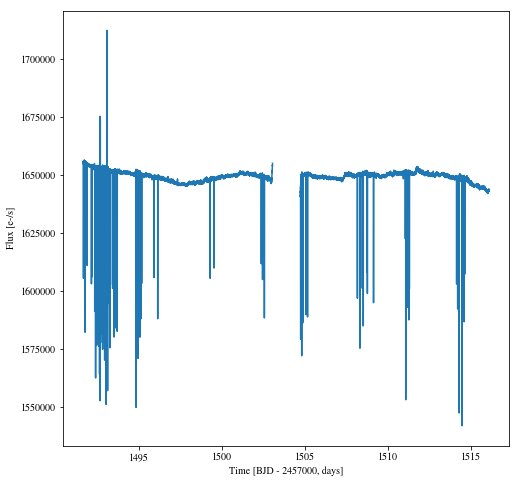

In [4]:
with fits.open(path+f1, mode='readonly') as hdulist:
    tess_bjds = hdulist[1].data['TIME']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_flux_error = hdulist[1].data['PDCSAP_FLUX_ERR']
    tess_quality = hdulist[1].data['QUALITY']

fig, axes = plt.subplots(figsize=(8,8))
axes.plot(tess_bjds, pdcsap_fluxes)
axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('Flux [e-/s]')

In [5]:
# Throw out NaN fluxes and do a quality cut
mask = ~np.isnan(pdcsap_fluxes)
time = tess_bjds[mask]
flux = pdcsap_fluxes[mask]
quality = tess_quality[mask]
median = np.median(flux)
error = pdcsap_flux_error[mask]

In [6]:
ok_cut = quality == 0
median = np.nanmedian(flux[ok_cut])

smo = IRLSSpline(time[ok_cut], flux[ok_cut]/median, error[ok_cut]/median)

sok_cut = np.isfinite(smo)

istart_i, istop_i = FINDflare((flux[ok_cut][sok_cut]-smo[sok_cut])/median, error[ok_cut][sok_cut]/median,
                               avg_std=False, N1=4, N2=2, N3=5)

print(str(len(istart_i)) + ' flares found')

0 flares found


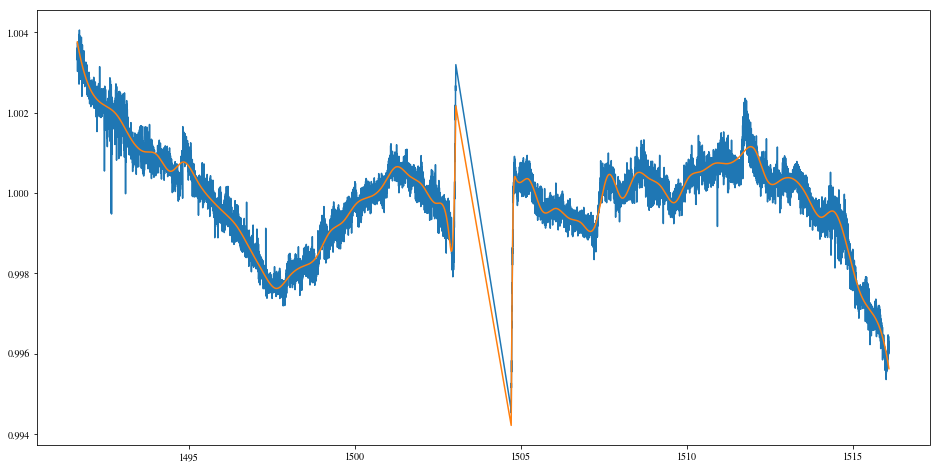

In [7]:
fig, axes = plt.subplots(figsize=(16,8))
axes.plot(time[ok_cut], flux[ok_cut]/median)
axes.plot(time[ok_cut][sok_cut], smo[sok_cut])

for idx in range(len((istart_i))):
    l = 'Flare?' if idx == 0 else '_nolabel_'
    axes.plot(time[ok_cut][sok_cut][istart_i[idx]:istop_i[idx]], 
              flux[ok_cut][sok_cut][istart_i[idx]:istop_i[idx]]/median, 'o', color='orange', label=l)

Text(0, 0.5, 'Flux [e-/s]')

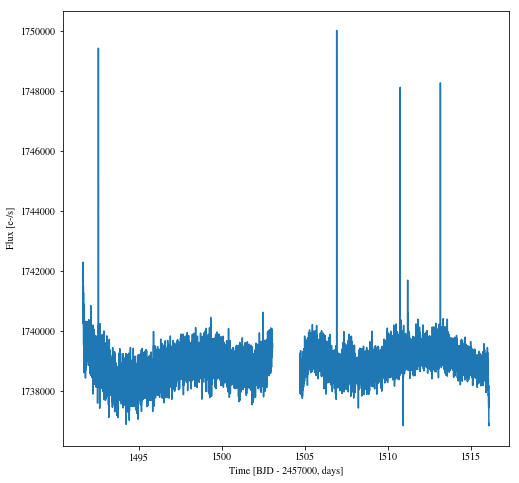

In [8]:
with fits.open(path+f2, mode='readonly') as hdulist:
    tess_bjds = hdulist[1].data['TIME']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_flux_error = hdulist[1].data['PDCSAP_FLUX_ERR']
    tess_quality = hdulist[1].data['QUALITY']

fig, axes = plt.subplots(figsize=(8,8))
axes.plot(tess_bjds, pdcsap_fluxes)
axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('Flux [e-/s]')

In [9]:
# Throw out NaN fluxes and do a quality cut
mask = ~np.isnan(pdcsap_fluxes)
time = tess_bjds[mask]
flux = pdcsap_fluxes[mask]
quality = tess_quality[mask]
median = np.median(flux)
error = pdcsap_flux_error[mask]

In [10]:
ok_cut = quality == 0
median = np.nanmedian(flux[ok_cut])

smo = IRLSSpline(time[ok_cut], flux[ok_cut]/median, error[ok_cut]/median)

sok_cut = np.isfinite(smo)

istart_i, istop_i = FINDflare((flux[ok_cut][sok_cut]-smo[sok_cut])/median, error[ok_cut][sok_cut]/median,
                               avg_std=False, N1=4, N2=2, N3=5)

print(str(len(istart_i)) + ' flares found')

1 flares found


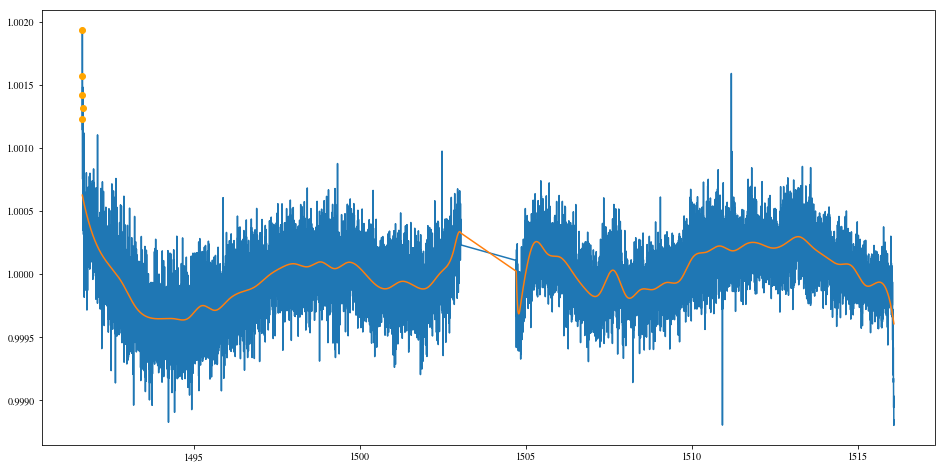

In [11]:
fig, axes = plt.subplots(figsize=(16,8))
axes.plot(time[ok_cut], flux[ok_cut]/median)
axes.plot(time[ok_cut][sok_cut], smo[sok_cut])

for idx in range(len((istart_i))):
    l = 'Flare?' if idx == 0 else '_nolabel_'
    axes.plot(time[ok_cut][sok_cut][istart_i[idx]:istop_i[idx]], 
              flux[ok_cut][sok_cut][istart_i[idx]:istop_i[idx]]/median, 'o', color='orange', label=l)

There is a large spike right at the beginning of the light curve. Is the spike always large like this?

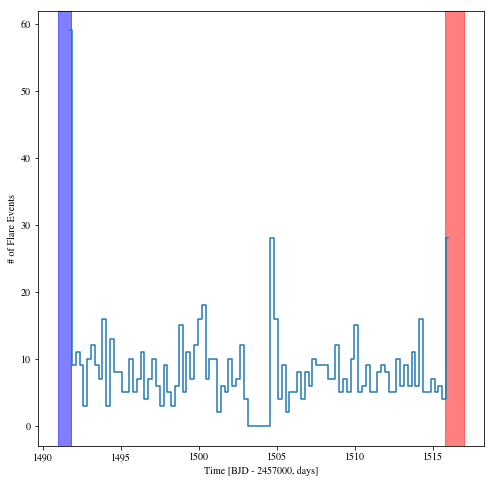

In [28]:
df = pd.read_csv('7.spline_flare_out.csv')

fig, axes = plt.subplots(figsize=(8,8))

hist, bins = np.histogram(df['t0'], bins=100)
bins = 0.5*(bins[1:] + bins[:-1])
axes.plot(bins, hist, linestyle='steps-mid')
axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('# of Flare Events')

left_cut1, left_cut2 = 1491, 1491.8
right_cut1, right_cut2 = 1515.8, 1517

axes.axvspan(left_cut1, left_cut2, alpha=0.5, color='b')
axes.axvspan(right_cut1, right_cut2, alpha=0.5, color='r')

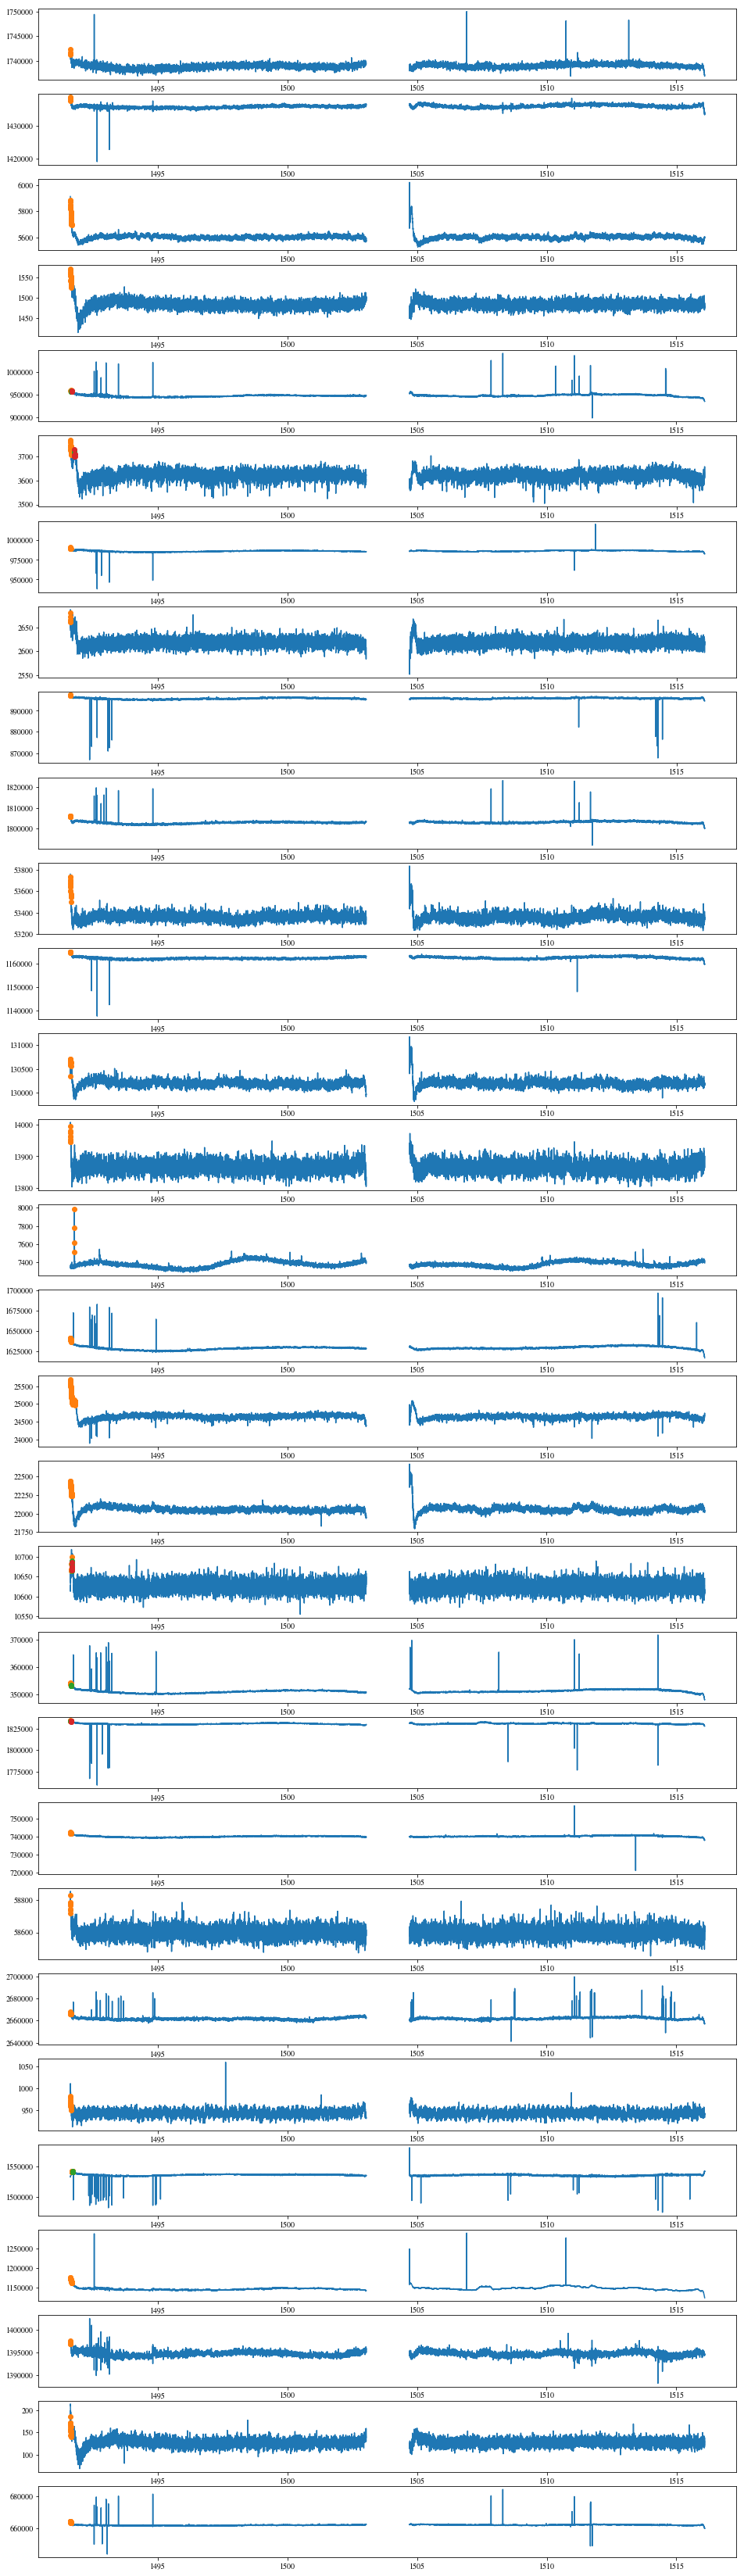

In [31]:
df_left = df[(df['t0'] > left_cut1) & (df['t0'] < left_cut2)]
df_left_unique = df_left.drop_duplicates('TIC')
idx_to_plot = range(len(df_left_unique[:30]))

fig, axes = plt.subplots(figsize=(16,2*len(idx_to_plot)), ncols=1, nrows=len(idx_to_plot))

for idx in idx_to_plot:
    TIC = df_left_unique.iloc[idx]['TIC']
    TIC_str = str(int(TIC)).zfill(16)
    file = 'tess2019006130736-s0007-'+TIC_str+'-0131-s_lc.fits'
    
    with fits.open(path+file, mode='readonly') as hdulist:
        tess_bjds = hdulist[1].data['TIME']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
        
    median = np.nanmedian(pdcsap_fluxes)
    axes[idx].plot(tess_bjds, pdcsap_fluxes + idx)
    
    tstart = df_left[df_left['TIC'] == TIC]['t0'].values
    tstop = df_left[df_left['TIC'] == TIC]['t1'].values
    for idx1 in range(len((tstart))):
        indices = np.where((tess_bjds >= tstart[idx1]) & (tess_bjds <= tstop[idx1]))[0]
        axes[idx].plot(tess_bjds[indices], pdcsap_fluxes[indices], 'o')

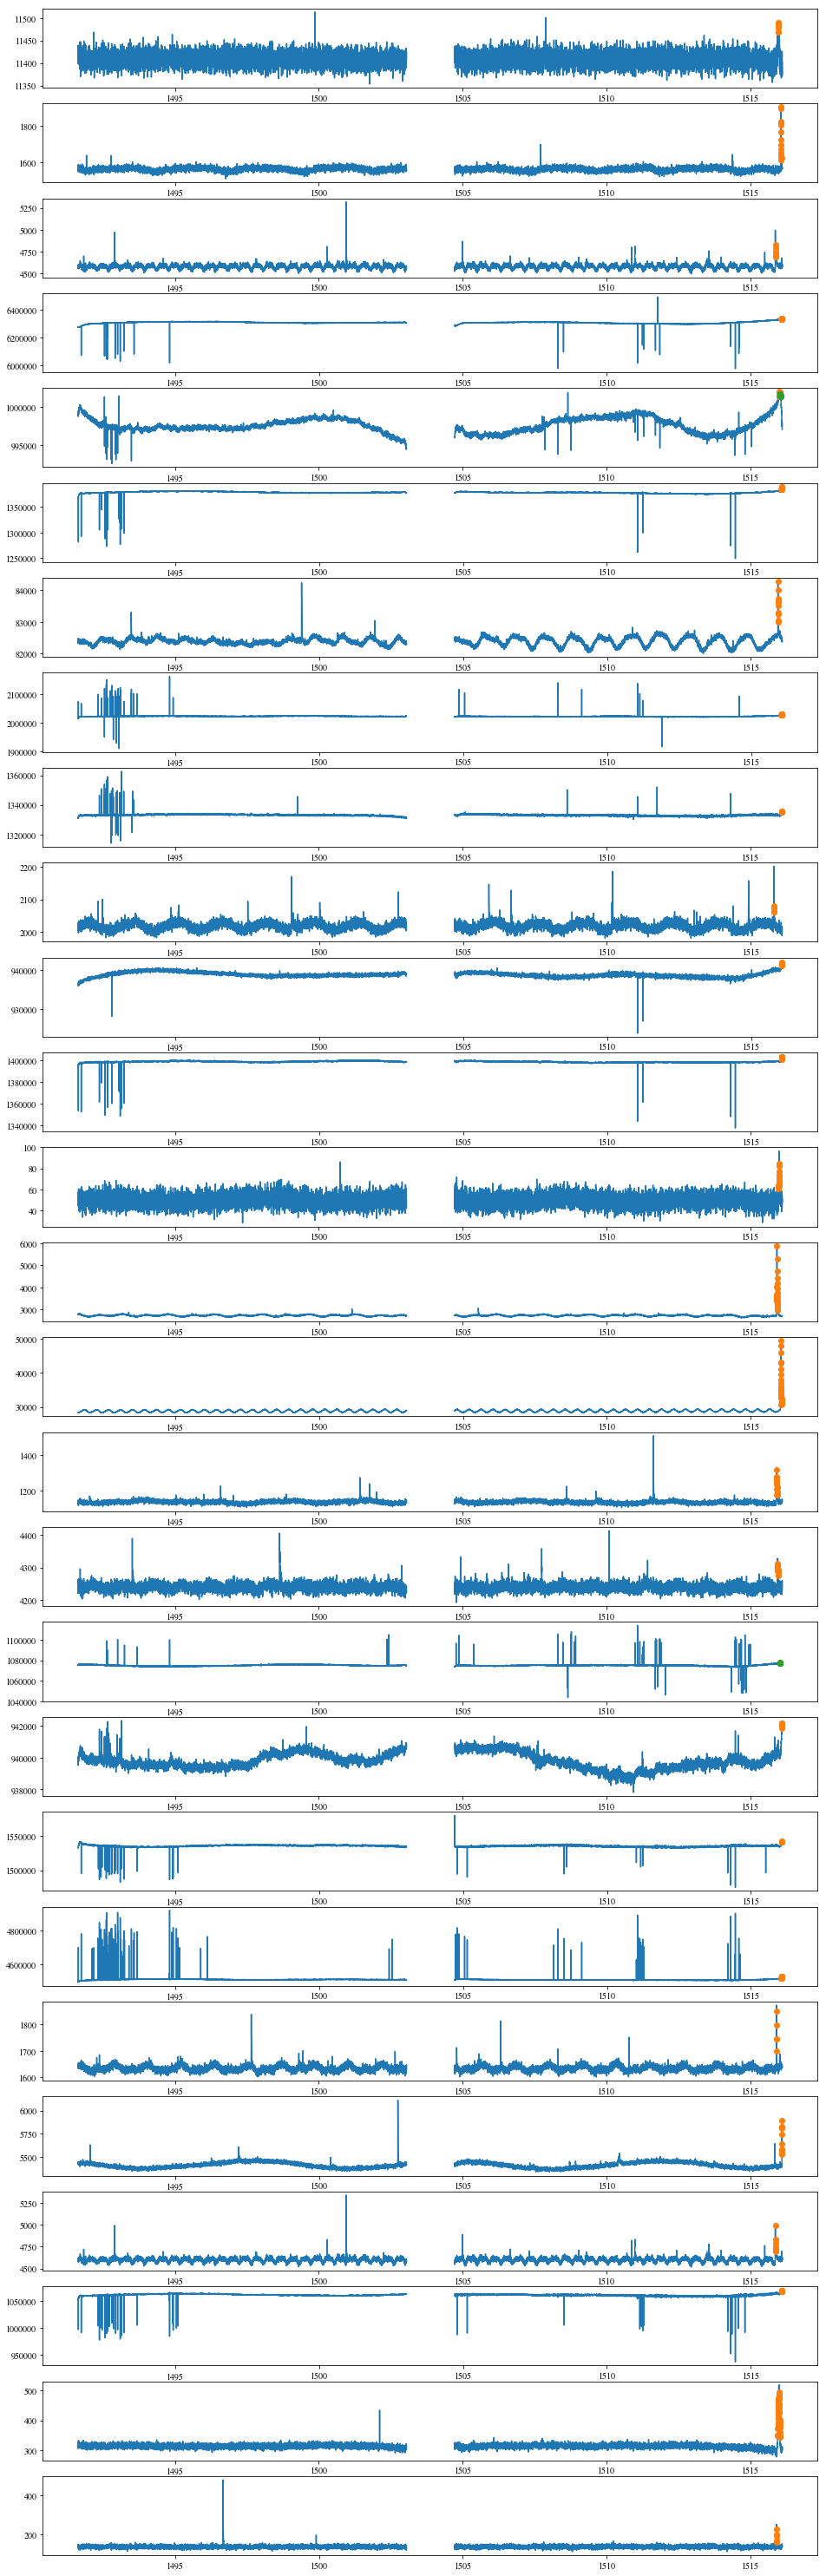

In [27]:
df_right = df[(df['t0'] > right_cut1) & (df['t0'] < right_cut2)]
df_right_unique = df_right.drop_duplicates('TIC')
idx_to_plot = range(len(df_right_unique[:30]))

fig, axes = plt.subplots(figsize=(16,2*len(idx_to_plot)), ncols=1, nrows=len(idx_to_plot))

for idx in idx_to_plot:
    TIC = df_right_unique.iloc[idx]['TIC']
    TIC_str = str(int(TIC)).zfill(16)
    file = 'tess2019006130736-s0007-'+TIC_str+'-0131-s_lc.fits'
    
    with fits.open(path+file, mode='readonly') as hdulist:
        tess_bjds = hdulist[1].data['TIME']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
        
    median = np.nanmedian(pdcsap_fluxes)
    axes[idx].plot(tess_bjds, pdcsap_fluxes + idx)
    
    tstart = df_right[df_right['TIC'] == TIC]['t0'].values
    tstop = df_right[df_right['TIC'] == TIC]['t1'].values
    for idx1 in range(len((tstart))):
        indices = np.where((tess_bjds >= tstart[idx1]) & (tess_bjds <= tstop[idx1]))[0]
        axes[idx].plot(tess_bjds[indices], pdcsap_fluxes[indices], 'o')